# Supplemental Figure 1

Plot to show that the results do not require strong assumptions about the type of encoding drift

- Show one example of each type of drift
- For each scenario plot NRMSE for each drift type, 10 seeds
- For non-sparse encoding, use the `ougaussian` features.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

'''
We need to use start-method 'spawn' or 'forkserver' for compatability
with Jax. 'forkserver' is allegedly faster. Spawn/forkserver starts 
each worker from a clean state. Code and data required to compute the 
job are serialized and sent to the worker. Functions being run should
be class methods (easily serialized). Any static initialization must
be done again, manually, in each worker process. We also need to use
multiprocess rather than multiprocessing to get around picking errors.
(Multiprocess uses  'dill' instead of pickle). When working on a 
remote server, workers should only print ASCII-compatible outputs to 
avoid unicode encoding errors in the worker processes. Also note that
both Jax and Multiprocessing will fail if the process IDs on the host
system have been exhausted, with obscure errors. 
'''
import multiprocess as multi
try:
    multi.set_start_method('spawn')
except RuntimeError:
    print('couldn\'t set context')
import master
from master   import *
from parallel import _parmap, helper, try_variations, methods
limit_cores()
debug = False
master.PRINT_LOGGING = not debug

## Define and run simulations for Fig. S1

In [2]:
nseeds     = 20
geometries = ['ring','line','tee']
scenarios =[
    {'method':'homeostat' ,'normalize':False},
    {'method':'hebbhomeo' ,'normalize':False},
    {'method':'hebbhomeo' ,'normalize':True },
    {'method':'predictive','normalize':True },
    {'method':'recurrent' ,'normalize':True }]
scenario_names = [
    'Homeostasis',
    'Hebbian homeostasis',
    'Response normalization',
    'Recurrent feedback',
    'Linear-nonlinear map']
features  =[
    {'features':'oneatatime','linearize':False},
    {'features':'ougaussian','linearize':False},
    {'features':'oumomentum','linearize':False},
    {'features':'ougaussian','linearize':True },]
feature_names = [
    'One at a time',
    'Random drift',
    'Directed drift',
    'Random drift (non-sparse)']

stability_jobs = [{**options,**s,**f,'geometry':t,'readout':t,'seed':i,**rates[s['method']]} 
        for i in range(nseeds) 
        for s in scenarios
        for f in features
        for t in geometries]
feature_jobs = [{**options,**scenarios[0],**f,'saveall':True,'seed':0} 
        for f in features]
results =  _parmap(helper, feature_jobs + stability_jobs)
feature_results   = results[:len(feature_jobs)]
stability_results = results[len(feature_jobs):]

notify('supplemental figure 1 simulation done')
fkeys = [(k,i,s,j)
    for j in range(nseeds) 
    for s in range(len(scenarios))
    for i in range(len(features))
    for k in range(len(geometries))]
fmap = dict([*zip(fkeys,stability_results)])

Shuffling job sequence
Parallel using 20 cores
>>> 20 cores available.
>>> limited each process to 1 cores.
Preparing to run 1204 jobs
Starting...
[████████████████████████████████████████]100.001% 

<IPython.core.display.Javascript object>

(0.0, 200.0) 200


<IPython.core.display.Javascript object>

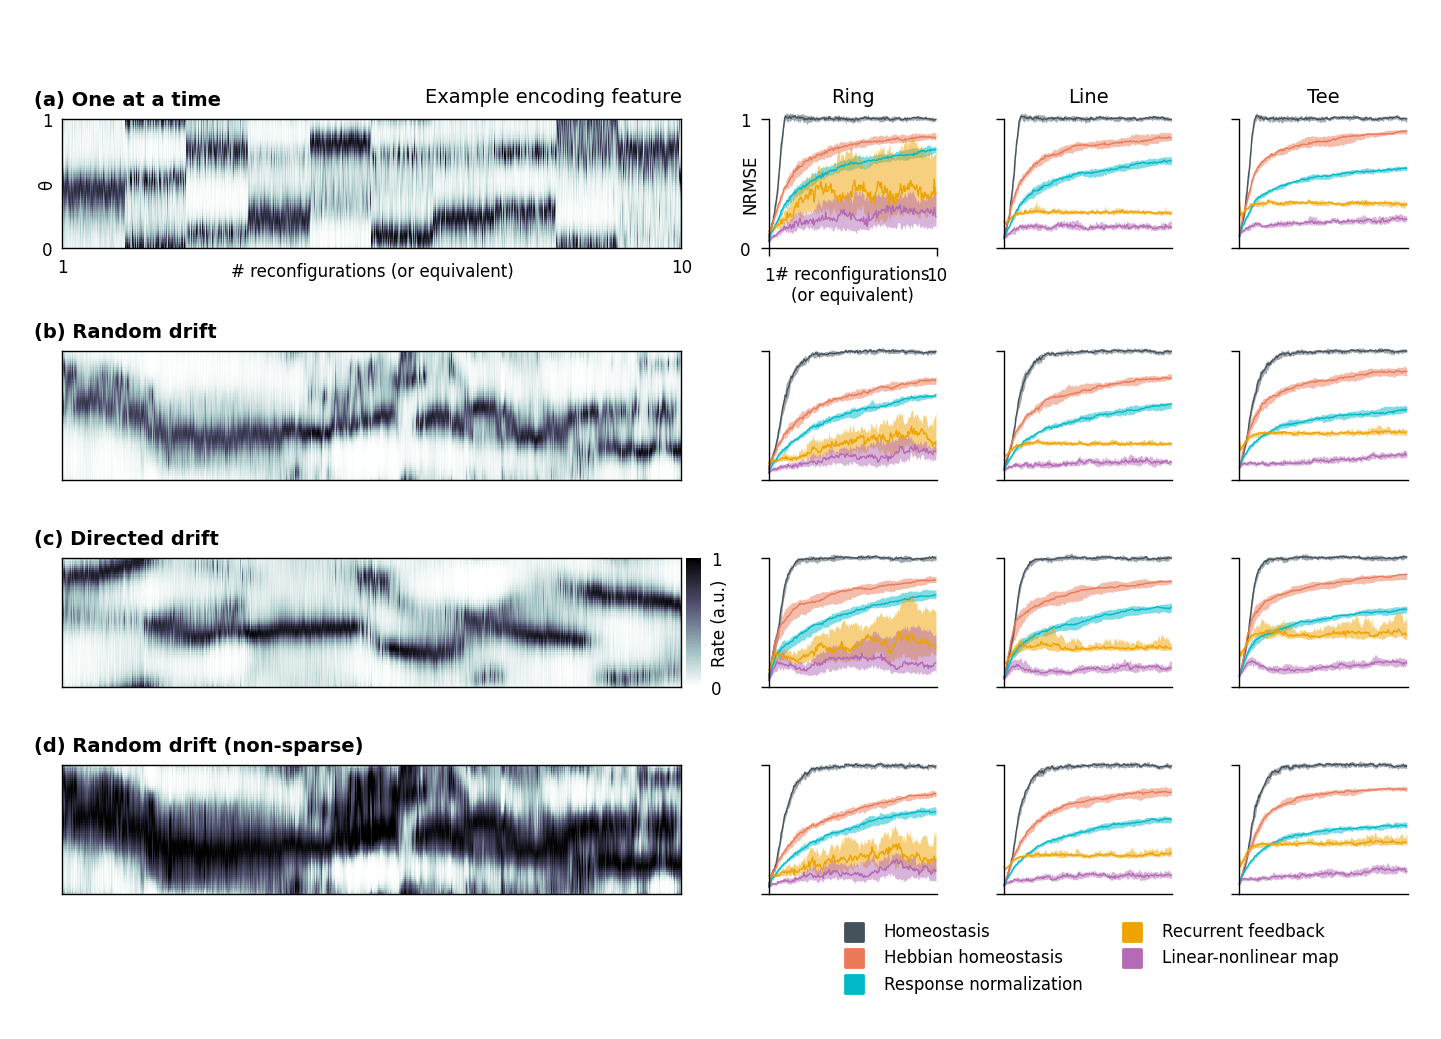

In [3]:
NTOP      = len(geometries)
NCOLF     = 3
NCOLS     = NCOLF + NTOP
NROWS     = len(features)
T         = options['T']
Δ         = options['Δ']
NSHOW     = T//Δ-1
NFEAT     = len(features)
NSCENARIO = len(scenarios)

figure(figsize=(PNAS_LARGE_WIDTH,5),dpi=200)

axs = {}
for i,f in enumerate(features):
    W0,X,Y0,Y,W,R,G,B = feature_results[i]
    axs[0,i] = subplot2grid((NROWS,NCOLS),(i,0),colspan=NCOLF)
    if i==3:
        X = scipy.stats.rankdata(X).reshape(*shape(X))
    imshow(X[:,1,:].T,extent=(1,NSHOW,0,1))
    nox(); noy(); 
axs[0,0].tick_params('both', which='both', length=0, width=0, labelsize=6)
sca(axs[0,0])
xlabel('# reconfigurations (or equivalent)',fontsize=6);
nicex(by=5); 
xticks([1,NSHOW],['1',NSHOW*options['Δ']//options['K']])
yticks([0,1]); 
ylabel('θ',fontsize=6); 
fudgey(5)

for k,t in enumerate(geometries):
    for i,f in enumerate(features):
        axs[k+1,i] = subplot2grid((NROWS,NCOLS),(i,NCOLF+k),colspan=1)
        # Plot stability for each readout plasticity scenario
        for s in range(NSCENARIO):
            drift = array([fmap[k,i,s,j] for j in range(nseeds)])
            drift = nan_to_num(drift,nan=1.0,posinf=1.0)
            l,μ,h = percentile(drift[:,:NSHOW],[25,50,75],axis=0)

            x     = (arange(len(μ)))[:NSHOW]
            color = [BLACK,RUST,TURQUOISE,OCHRE,MAUVE][s]
            plot(x[:NSHOW], μ[:NSHOW], 
                clip_on=False,
                color=color,
                lw   =.5)
            fill_between(x[:NSHOW],l[:NSHOW],h[:NSHOW],
                clip_on=False,
                color=color,
                alpha=0.5,
                lw=0)
            # Add fake markers if on bottom axis
            if k==1 and i==len(features)-1:
                scatter([-100],[0.5],marker='s',s=40,
                        color=color,
                        label=scenario_names[s])
        simpleaxis()
        xlim(0,NSHOW)
        ylim(0,1)
        # Title only on top
        if i==0:
            title(geometries[k].title(),fontsize=MEDIUM)
        # Detailed labels only on top left
        if i==0 and k==0: 
            ylabel('NRMSE',fontsize=6)
            yticks([0,1])
            fudgey(7)
            xlabel('# reconfigurations\n(or equivalent)',fontsize=6)
            print(xlim(),NSHOW)
            xticks([1,NSHOW],['1',NSHOW*options['Δ']//options['K']])
            fudgex(7)
            gca().tick_params(axis='both', which='both', labelsize=SMALL)
        else:
            yticks([0,1],['',''])
            nox()
        # Legend only on bottom middle
        if k==1 and i==len(features)-1:
            baselegend(fontsize=6,ncol=2)

tight_layout()
subplots_adjust(bottom=0.125,top=0.875,right=.99,wspace=0.4,hspace=0.6)
[nudge_axis_y(25,axs[i,0]) for i in range(4)]
for i in range(NFEAT):
    sca(axs[0,i])
    subfigurelabel('(%s) %s'%('abcdef'[i],feature_names[i]),fontsize=MEDIUM,dx=29,dy=10)
    nudge_axis_x(-20)
    nudge_axis_left(20)
sca(axs[0,2])
good_colorbar(0,1,'bone_r','Rate (a.u.)',fontsize=SMALL)
sca(axs[0,0])
title('Example encoding feature',loc='right',fontsize=MEDIUM)
figurebox('w')
savefigure('s1.pdf',stamp=False)
notify('s1 plotted')